The purpose of this notebook is to work on the famous MNIST dataset for digit handwritten recognition. I'm going to use Keras library for the convolutional neural network. 

Let's start with reading the training data.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(7)

In [2]:
directory = '../../Datasets/Digital_Recognizer/'
train_input = pd.read_csv(directory + 'train.csv')

In [3]:
train_target = train_input['label']
train_input.drop(['label'], axis=1, inplace=True)

In [4]:
train_input = train_input.astype('float32')
train_input = train_input / 255.
train_input = train_input.values

We can take a look at the first 10 samples to better understand the problem.

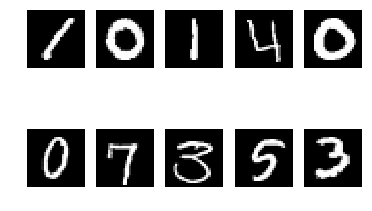

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
f, axarr = plt.subplots(2, 5)
for i in range(0,2):
    for j in range(0,5):
        axarr[i][j].imshow(train_input[i*5+j, :].reshape(28, 28), cmap=cm.Greys_r)
        axarr[i][j].axis('off')

The target array that we have includes a single number from 0 to 9. We need to convert that to categorical 0/1 values.

In [6]:
train_target.shape

(42000,)

In [7]:
train_target[0:10]

0    1
1    0
2    1
3    4
4    0
5    0
6    7
7    3
8    5
9    3
Name: label, dtype: int64

In [8]:
from keras.utils.np_utils import to_categorical
train_target = to_categorical(train_target, 10)

Using TensorFlow backend.


In [9]:
train_target[0:10]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now, let's do the normal training/validation set split. I'll use 20% of the training data to be used for validation.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(train_input, train_target, test_size=0.20, random_state=0)

I'll use dropout for regulation. Also, we need to change the shape of input array for the convNN (see below).

In [11]:
batch_size = 256

epochs = 20
dropout = 0.05
num_classes = 10

X_train = X_train.reshape(-1, 28, 28, 1)
X_cv = X_cv.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(10, activation='softmax'))

The above model is a normal Conv2D architecture. We can fine tune it later to improve the accuracy. 

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [14]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

The are several discussions (see [here](http://yann.lecun.com/exdb/mnist/index.html) about using elastic distortion for data agumentation). I'm goint to try a simple one for now. There are many paramters that can be used for this purpose.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range = 1,
                            rotation_range = 15)

In [16]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()       
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(X_train)//batch_size,
                           epochs=epochs,
                           verbose=2,
                           validation_data=(X_cv,y_cv), callbacks=[history])

Epoch 1/20
103s - loss: 1.0792 - acc: 0.6418 - val_loss: 0.1841 - val_acc: 0.9514
Epoch 2/20
102s - loss: 0.6211 - acc: 0.7940 - val_loss: 0.0948 - val_acc: 0.9719
Epoch 3/20
100s - loss: 0.5188 - acc: 0.8269 - val_loss: 0.0886 - val_acc: 0.9730
Epoch 4/20
99s - loss: 0.4700 - acc: 0.8420 - val_loss: 0.0739 - val_acc: 0.9792
Epoch 5/20
100s - loss: 0.4254 - acc: 0.8556 - val_loss: 0.0678 - val_acc: 0.9790
Epoch 6/20
100s - loss: 0.4120 - acc: 0.8624 - val_loss: 0.0500 - val_acc: 0.9843
Epoch 7/20
99s - loss: 0.3840 - acc: 0.8724 - val_loss: 0.0585 - val_acc: 0.9808
Epoch 8/20
100s - loss: 0.3733 - acc: 0.8760 - val_loss: 0.0376 - val_acc: 0.9881
Epoch 9/20
101s - loss: 0.3598 - acc: 0.8784 - val_loss: 0.0377 - val_acc: 0.9876
Epoch 10/20
100s - loss: 0.3502 - acc: 0.8810 - val_loss: 0.0384 - val_acc: 0.9876
Epoch 11/20
100s - loss: 0.3305 - acc: 0.8878 - val_loss: 0.0302 - val_acc: 0.9898
Epoch 12/20
101s - loss: 0.3290 - acc: 0.8870 - val_loss: 0.0413 - val_acc: 0.9863
Epoch 13/20
100

In [17]:
# check the wrong images
p_cv = np.round(model.predict(X_cv)).argmax(axis=1)
wrong_pixels = X_cv[p_cv != y_cv.argmax(axis=1)]
print('[CV]: number of wrong items is:', len(wrong_pixels), 'out of', len(X_cv))

[CV]: number of wrong items is: 76 out of 8400


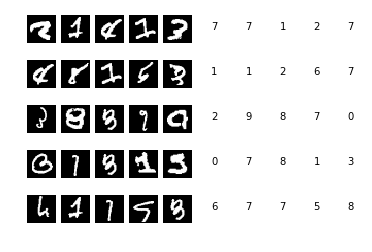

In [18]:
f, axarr = plt.subplots(5, 10)
for i in range(0, 5):
    for j in range(0, 5):
        idx = np.random.randint(0, wrong_pixels.shape[0])
        axarr[i][j].imshow(wrong_pixels[idx, :].reshape(28, 28), cmap=cm.Greys_r)
        title = str(model.predict(wrong_pixels[idx, :].reshape(1, 28, 28, 1)).argmax())
        axarr[i][j + 5].text(0.5, 0.5, title)
        axarr[i][j].axis('off')
        axarr[i][j + 5].axis('off')

plt.show()

The accuracy of the trained model is 99.14% which is very good given the fact that we can increase epochs and also we can improve the architecture of the conv network and the elastic distortion parameters.  